In [1]:
from dataset import Dataset
import torch
from my_batch_loader import BatchLoader
from models import Embedding, Generator, Discriminator
from train import Trainer
from torch import nn
from functools import partial
import math
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt
import io
from itertools import cycle

In [2]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))

device is cuda


In [3]:
# dataset
ds = Dataset(corp_paths=('./data/train.lc.norm.tok.en', './data/train.lc.norm.tok.fr'),
             emb_paths=('./data/wiki.multi.en.vec', './data/wiki.multi.fr.vec'),
             pairs_paths=('./data/full_en_fr.npy', './data/full_fr_en.npy'),
             max_length=20, test_size=0.1)
print('finish loading dataset')

Files already exit.
finish loading dataset


In [4]:
# batch iterator
batch_size = 64
batch_iter = BatchLoader(ds, batch_size=batch_size)
print('finish creating batches')

finish creating batches


In [5]:
src_embedding = Embedding(ds.emb_matrix['src'], requires_grad=True)
tgt_embedding = Embedding(ds.emb_matrix['tgt'], requires_grad=True)

bidirectional = True
hidden_size = 300
num_directions = 2 if bidirectional else 1
assert hidden_size % num_directions == 0
en_hidden_size = hidden_size // num_directions

encoder_rnn = nn.LSTM(input_size=src_embedding.embedding_dim, hidden_size=en_hidden_size,
                      num_layers=3, dropout=0.3, bidirectional=True)

decoder_rnn = nn.LSTM(input_size=src_embedding.embedding_dim, hidden_size=300,
                      num_layers=3, dropout=0.3)

src_generator = Generator(hidden_size=hidden_size, vocab_size=ds.vocabs['src'].size)
tgt_generator = Generator(hidden_size=hidden_size, vocab_size=ds.vocabs['tgt'].size)

discriminator = Discriminator(max_length=20, encoder_hidden_size=300, hidden_size=1024, n_layers=3)
# trainer
trainer = Trainer(partial(ds.translate_batch_word_by_word, l1='src', l2='tgt'),
                  partial(ds.translate_batch_word_by_word, l1='tgt', l2='src'),
                  src_embedding, tgt_embedding, encoder_rnn, decoder_rnn, src_generator, tgt_generator,
                  discriminator, hidden_size, 20,
                  ds.get_sos_index('src'), ds.get_sos_index('tgt'),
                  ds.get_eos_index('src'), ds.get_eos_index('tgt'),
                  ds.get_pad_index('src'), ds.get_pad_index('tgt'),
                  device, lr_core=0.0003, lr_disc=0.0005)

#trainer.load('../saved_models/final_result1/')
print('finish initializing models')

finish initializing models


In [6]:
# training
num_epochs = 1
core_losses = []
disc_losses = []

src_data = batch_iter.data_loader['train']['src']
tgt_data = batch_iter.data_loader['train']['tgt']

for e in tqdm(range(num_epochs)):
    # re-initialize the parameters
    trainer.re_init_params()
    # the target source is lesss, so cycle it
    for i, batch in enumerate(zip(src_data, cycle(tgt_data))):
        # length first, batch second
        src_batch = batch[0][1].transpose(0, 1)
        tgt_batch = batch[1][1].transpose(0, 1)
        b = {'src': src_batch, 'tgt': tgt_batch}
        core_loss, disc_loss = trainer.train_step(b, weights=(1, 1, 1))
        core_losses.append(core_loss)
        disc_losses.append(disc_loss)

    # set word_to_word translate false
    trainer.word_word_translate = False    
    
    # deepcopy the current parameters
    trainer.frozen_src2tgt = copy.deepcopy(trainer.src2tgt)
    trainer.frozen_tgt2src = copy.deepcopy(trainer.tgt2src)

    trainer.src_embedding = copy.deepcopy(trainer.src_embedding)
    trainer.tgt_embedding = copy.deepcopy(trainer.tgt_embedding)
    trainer.encoder_rnn = copy.deepcopy(trainer.encoder_rnn)
    trainer.decoder_rnn = copy.deepcopy(trainer.decoder_rnn)
    trainer.src_hat = copy.deepcopy(trainer.src_hat)
    trainer.tgt_hat = copy.deepcopy(trainer.tgt_hat)
    
    # freeze the translaters
    for param in trainer.frozen_src2tgt.parameters():
        param.requires_grad = False
    for param in trainer.frozen_tgt2src.parameters():
        param.requires_grad = False
        
#     trainer.word_word_translate = False
#     trainer.frozen_src2tgt = trainer.src2tgt
#     trainer.frozen_tgt2src = trainer.tgt2src
#     trainer.src2tgt = copy.deepcopy(trainer.src2tgt)
#     trainer.tgt2src = copy.deepcopy(trainer.tgt2src)
#     for param in trainer.frozen_src2tgt.parameters():
#         param.requires_grad = False
#     for param in trainer.frozen_tgt2src.parameters():
#         param.requires_grad = False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:24<00:00, 324.65s/it]


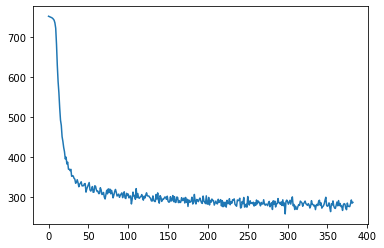

In [7]:
plt.plot(core_losses)
plt.show()

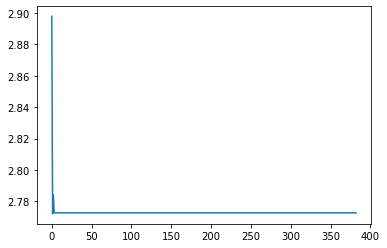

In [8]:
plt.plot(disc_losses)
plt.show()

In [9]:
torch.save(trainer.src2tgt, './saved_models/en-fr/' + str(num_epochs) + '_word_to_word_1_' + str(num_epochs - 1) + '.src2tgt.pt')
torch.save(trainer.tgt2src, './saved_models/en-fr/' + str(num_epochs) + '_word_to_word_1_' + str(num_epochs - 1) + '.tgt2src.pt')
print('model saved.')

model saved.


In [10]:
# trainer.save('./saved_models/20_word_to_word_5_self/')
# print('model saved.')
path = './predictions/en-fr/src_predictions_bs_' + str(batch_size) + '_ne_' + str(num_epochs) + '_w_'+ str(1) + '_s'
print(path)

./predictions/en-fr/src_predictions_bs_64_ne_1_w_1_s


In [11]:
# predict on source (en to fr)
src_test = batch_iter.data_loader['test']['src']
tgt_test = batch_iter.data_loader['test']['tgt']
src_predictions = []
for i, batch in enumerate(src_test):
    length = batch[0]
    b = batch[1].transpose(0, 1)
    src_predictions += trainer.predict_on_test((length, b), visualize=ds.visualize_batch, l1='src', l2='tgt', n_iters=20)
with io.open(path, 'w') as f:
   print(*src_predictions, sep='\n', file=f)
print('finish predicting')

finish predicting
